# Introduction to image classification with AutoGluon Efficientnet model

1. [Introduction](#Introduction)
2. [Dataset](#Dataset)
3. [Import python modules](#Import-python-modules)
4. [Train the model using Amazon SageMaker](#Train-the-model)
5. [Compile model using SageMaker Neo](#Compile-model)
6. [Upload model to S3 bucket](#Upload-model)
7. [Run inference on Edge device](#Run-inference)

## Introduction

This is an end-to-end example of training and optimization of image classification model using Amazon SageMaker. The example illustrates training an Autogluon model with SageMaker followed by compilation with SageMaker Neo. The model classifies image based on the fingers visible. An Efficientnet model is used for the classification purpose.The model compilation is performed for Jetson Nano. 

Please refer the following links for basic familiarity for training and compiling model using Amazon SageMaker.
* [Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-training.html)
* [SageMaker Neo](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html)
* [Amazon S3 bucket](https://aws.amazon.com/s3)

__Kernel for notebook__

This notebook requires conda_mxnet_p36 kernel. So set the kernel of the notebook. You can select the kernel from the top right corner.

**Note: The notebook is an example and provides finger count classification model.**

## Dataset

Hand gestures has been widely used in sign language, robotics, medical systems and assistive systems. Hand gestures are useful for the human-machine communications since they are expressive. Finger counting is a part of hand gestures. Image classification is widely applied in the fields of hand gesture recognition. The fingers in an image can be classified using convolutional neural networks. Image classification model predicts the class of the object in the image. Classification tasks can be single label or multi-label. In this classification task the model predicts number of fingers in the image or whether it is the background. The model counts upto 5 fingers. There are 7 classes in the dataset, [background, 0, 1, 2, 3, 4, 5]. Samples from the classes 5 and 1 are shown below.

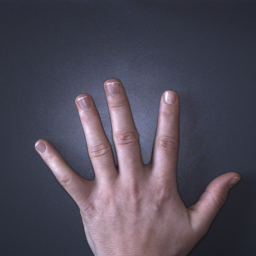
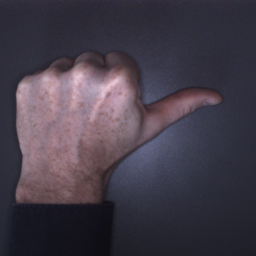

## Import python modules

[Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html) is a high level library that encapsulates the SageMaker functionalities to train and compile a model. The library contains implementations for frameworks such as TensorFlow, MXNet, PyTorch and so on. 

[Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) is a Python SDK that enables to use Amazon Web Services(AWS) services. Here boto3 is used for accessing the S3 bucket.

In [1]:
import sagemaker
import boto3

### Get the region of notebook instance and S3 bucket.

The notebook instance and S3 bucket should be in the same region. Notebook instance can access only the S3 bucket in the same region. If the region is same for both the instance and bucket, we can proceed with the training, else it results in an error.

Here in the following code, enter your bucket name instead of ___< my bucket name >__.

In [2]:
bucket = '< my bucket name >'

region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=bucket)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "Your S3 bucket {} and this notebook should be in the same region.".format(bucket)

### SageMaker execution role and Session

IAM role for the notebook instance. We can obtain the role using the function __get_execution_role()__. We pass this role as an argument for the training job.

Session manages the interaction between SageMaker functionalities and other AWS services. [sagemaker session](https://sagemaker.readthedocs.io/en/stable/api/utility/session.html#)

Default bucket - The S3 bucket to store train, labels, and output data from this training session. 

In [3]:
from sagemaker import get_execution_role

role = get_execution_role()
sess = sagemaker.Session(default_bucket=bucket)
bucket = sess.default_bucket()
print('Default bucket is {}'.format(bucket))

Default bucket is evs-sagemaker-studio-test


## Train model using SageMaker

### Transfer learning

Here we use a custom Python code to train a model using estimator class MXNet(). The MXNet class used for training is derived from the Estimator class.[MXNet Estimator](https://sagemaker.readthedocs.io/en/stable/frameworks/mxnet/sagemaker.mxnet.html).

The training script contains the preparation of training data, fine-tuning the Efficientnet model based on the input hyperparameters. 

#### EfficientNet

Certain CNNs cane be scaled for better accuracy or performance. EfficientNet performs scaling of dimensions width /depth/input size fo the network. EfficientNet provides better accuracy and performance when compared to the the other networks and the network can be modfied with the width,depth,input factors for our task. See [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) for more information. There are 8 EfficientNet models based on the scaling. Select the network according to your wish for training. 

In this example, efficientnet-b0 is used for the classification. We use transfer learning for better results. The base network is trained using  [ImageNet](http://image-net.org/index). In the fine-tuning session the last layer is replaced with new classes and the network is trained to obtain better results. The input image size for the model is 224 x 224. In this example, the hyperparameters, epochs and data-shape, are initialized. The other parameters use default values. It can be set according to your task using the argument list in the training code. AutoGluon toolkit is used to train the model. AutoGluon toolkit enables easy solution for machine learning problems. The toolkit includes easy training of deep learning model using 3 steps, dataset preparation, fit the model and prediction by the model. It can be used with external libraries such as PyTorch.

* Deep learning toolkit - [AutoGluon](https://auto.gluon.ai/v0.0.14/index.html#)
* Introduction to transfer learning - [Transfer learning for Deep Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)



#### Set the paths to train, test and labels data

In [5]:
 # the folder in which label file and images has to be stored.
train_data_prefix = 'hand-classification-test/dataset/train'
test_data_prefix = 'hand-classification-test/dataset/test'

#### Create class list

The class list contains 7 classes.

In [ ]:
CLASS_NAMES = ['zero','one','two','three','four','five','background']
CLASS_FILE = 'classes.lst'

# write the class names to a text file
with open(CLASS_FILE,'w') as f:
    for i in range(0, len(CLASS_NAMES)):
        f.write('{}\n'.format(CLASS_NAMES[i]))
f.close()

print('Classes are \n'+ str(CLASS_NAMES))

The images are grouped to different folders based on their classes. The folder 'zero' has images with zero finger counts. The classes will be sorted according to the folder names. 

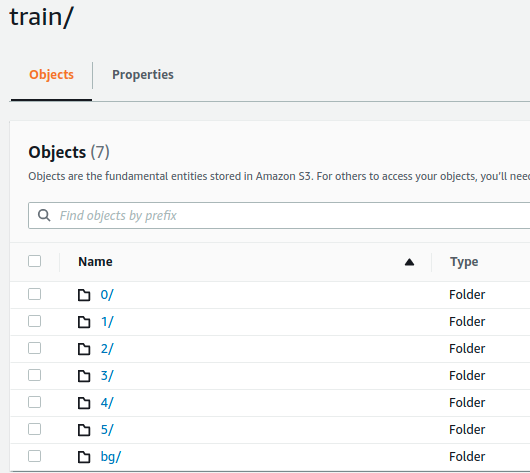

In [6]:
s3_train_data = 's3://{}/{}'.format(bucket,train_data_prefix)
s3_test_data = 's3://{}/{}'.format(bucket,test_data_prefix)

In [7]:
print(s3_train_data)
print(s3_test_data)

s3://evs-sagemaker-studio-test/hand-classification-test/dataset/train
s3://evs-sagemaker-studio-test/hand-classification-test/dataset/test


#### Prepare the MXNet estimator for training

Set the output path for log, checkpoints and model. Set the hyperparameters and GPU instance for training.

The model was trained using **ml.p3.2xlarge** GPU instance. The EC2 instance price per hour is listed in [EC2 instance pricing](https://aws.amazon.com/ec2/pricing/on-demand/).You can change the instance using the parameter __instance_type__ in the MXNet().

Use [accelerated computing instances](https://aws.amazon.com/ec2/instance-types/) for the training. The list of ec2 instances supported by SageMaker for training can be obtained from [Amazon SageMaker Pricing](https://aws.amazon.com/sagemaker/pricing/)  

The __Estimator__ class in Amazon SageMaker Python SDK is used to set the training parameters and fit the model. [Estimator in Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In [8]:
prefix = 'hand-classification-example'
# output location to save model files
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

# Location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://{}/{}/customcode'.format(bucket, prefix)

#### Set learning parameters

In [14]:
from sagemaker.mxnet import MXNet
from sagemaker.utils import name_from_base

model_estimator = MXNet(entry_point='finger_count_classification_entry.py',
                      role=role,
                      output_path=s3_output_location,
                      code_location=custom_code_upload_location,
                      instance_count=1,
                      instance_type='ml.p3.2xlarge',
                      framework_version='1.7.0',
                      py_version='py3',
                      hyperparameters={'batch-size':64,
                                       'epochs':20,
                                       'final-fit-epochs':150,
                                       'num-trials':10,
                                       'ngpus-per-trial':1,
                                       'networks':"['efficientnet_b0']"
                                      }
                     )

### Fit model

The estimator class has fit() which calls the train() in the entry point python file. We can see the logs in the output. If more information is required, we can set the log in the python code. 

__Note__: Get the current status, monitor, or change status your training from __Amazon SageMaker -> Training Jobs -> _your training job___. The training job cannot be stopped from the notebook. If required, stop the job from __Training Jobs__.

___Give a unique job name for the training. Job name should be unique similar to notebook instance name. The characters should be ^[a-zA-Z0-9](-*[a-zA-Z0-9])*___. This notebook generates a unique name for each training job. The name will be _job$_$name_ with datetime 

_This example was trained on a subset of the dataset._

In [15]:
job_name = name_from_base('hand-classification')
model_estimator.fit({'train': s3_train_data,'test': s3_test_data},job_name = job_name)

2021-02-12 16:22:15 Starting - Starting the training job...
2021-02-12 16:22:39 Starting - Launching requested ML instancesProfilerReport-1613146935: InProgress
......
2021-02-12 16:23:40 Starting - Preparing the instances for training......
2021-02-12 16:24:43 Downloading - Downloading input data......
2021-02-12 16:25:41 Training - Downloading the training image.....2021-02-12 16:26:28,187 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-02-12 16:26:28,215 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"batch-size":8,"epochs":5,"final-fit-epochs":5,"networks":"[\'efficientnet_b0\']","ngpus-per-trial":1,"num-trials":4}', 'SM_USER_ENTRY_POINT': 'hand_classification_entry.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CONFIG': '{"test":{"Re

In [16]:
# Download model from S3 to the current directory
output_path_prefix = '{}/output/{}/output/model.tar.gz'.format(prefix,job_name)
path =sess.download_data('./',bucket, key_prefix=output_path_prefix)

## Compile model

Compile the model for optimal inference on Jetson Nano. The __compile_model()__ is used for model compilation. The SageMaker Neo compiles the model in S3 output location such that the optimal model is obtained for the target device __Jetson Nano__.

For more information, please have a look at the following websites.

[SageMaker Neo](https://docs.aws.amazon.com/sagemaker/latest/dg/neo.html)


[Neo Troubleshooting](https://docs.aws.amazon.com/sagemaker/latest/dg/neo-troubleshooting.html)

In [17]:
input_size = 224
# input shape to the model
input_data = '{"data":[1,3,' + str(input_size)+ ',' + str(input_size)+ ']}'

# edge device configuration
target_platform_os = "LINUX"
target_platform_arch = "ARM64"
target_platform_accelerator = "NVIDIA"
compiler_options = {'gpu-code': 'sm_53', 'trt-ver': '6.0.1', 'cuda-ver': '10.0'}

# framework of pretrained model
framework = 'mxnet'
compiled_model = model_estimator.compile_model(target_instance_family = None,
                                             input_shape = input_data,
                                             target_platform_os = target_platform_os,
                                             target_platform_arch = target_platform_arch,
                                             target_platform_accelerator = target_platform_accelerator,
                                             compiler_options = compiler_options,
                                             framework=framework,
                                             framework_version='1.7.0',
                                             output_path=s3_output_location
                                            )

?.....................................!

Devices described by Target Platform OS, Architecture and Accelerator are notsupported for deployment via SageMaker. Please deploy the model manually.


In [18]:
print('Compiled model can be found in {}'.format(s3_output_location))

Compiled model can be found in s3://evs-sagemaker-studio-test/hand-classification-example/output


## Download compiled model to the notebook instance

Download the compiled model from S3 path to the working directory in notebook instance.

In [19]:
compiled_model_name = '{}-{}_{}_{}.tar.gz'.format('model', target_platform_os,target_platform_arch,target_platform_accelerator)
output = '{}/output/{}'.format(prefix,compiled_model_name)
sess.download_data('./',bucket,key_prefix=output)

### Add class list to the compiled model and upload it to the desired S3 bucket

In [20]:
!mkdir compiled_model
!mv classes.lst compiled_model/

In [ ]:
import os 

command = 'tar xvf '+compiled_model_name+' -C compiled_model'
os.system(command)

In [34]:
new_model_name = 'finger-count-classification-model.tar.gz'
command = 'tar -C compiled_model -czvf ' + new_model_name + ' .'
os.system(command)

0

In [35]:
!rm -r compiled_model/

In [ ]:
# upload model to the destination bucket
prefix = prefix + '/compiled_model'
model_path = sess.upload_data(path=new_model_name, key_prefix= prefix)

# prints the path to the compressed model
print('S3 file path ' +model_path)

### Run the inference on Jetson Nano